Generate precipitation indices from the LOCA data to compare impacts of spatial resolution and location

In [1]:
# Import packages
import numpy as np
import pandas as pd
import xarray as xr
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from geocat.viz import util as gvutil 
import regionmask

import geoplot as gplt
import geopandas as gpd
import mapclassify as mc


In [40]:
import climdex.precipitation as pdex
indices = pdex.indices(time_dim='time')

iDir = "~/PROGS/Belmont FWE/LOCA-data/loca5/"
oDir = "~/PROGS/Belmont FWE/Indices/"

Define the precipitation functions

In [3]:
def yearly_rx1day(ds, varname = 'PRECT'):
    """
    Compute the annual maximum 24h precipitation total
    Args:
        ds: Dataset
        varname: assumes 'PRECT' 
    """
    ds = xr.DataArray(ds[varname].groupby('time.year').max('time'), name='RX1D')

    return ds
    
def yearly_rx5day(ds, varname = 'PRECT'):
    """
    Compute the annual maximum 5 day precipitation total
    Args:
        ds: Dataset
        varname: assumes 'PRECT'
    """
    ds = xr.DataArray(ds[varname].rolling(time=5).sum().groupby('time.year').max('time'), name='RX5D')

    return ds

def r_quant(ds, threshold=0.95, time0='2015-01-01', time1='2034-12-31', varname='PRECT'):
    """
    Compute quantiles in rainfall data. Calculates for days with >=1mm.
    Args:
        ds: Dataset.
        varname: PRECT (assumes CESM output)
        threshold (float): Lower quantile percent (as decimal). Defaults to 0.95
        time0 (str): First time for slice. Defaults to 2015-01-01.
        time1 (str): Second time for slice. Defaults to 2034-12-31.
    """
    dp = ds.sel(time=slice(time0,time1)).where(ds[varname] > 1).quantile(q=[threshold],dim=['time']).squeeze().drop('quantile')
    dp = dp.to_array(name=(f"Q{str(int(float(threshold)*100))}"))
    return dp

def annualtot_above_q(ds, thresh_data, threshold=0.95, varname='PRECT'):
    """
    Compute total precipitation from days exceeding threshold
    Args:
        ds: Dataset.
        thresh_data: Threshold dataset (computed using r_quant over all projs).
        threshold (float): Upper quantile percent (as decimal) defaults to 0.95
        varname: PRECT. assumes CESM output
    """
    ds = xr.where(ds[varname] > thresh_data,ds[varname],0).groupby('time.year').sum('time')
    ds = ds.to_array(name = (f"PR{str(int(float(threshold)*100))}Tot")).squeeze().drop('variable')
    return ds

def annualnum_above_q(ds, thresh_data, threshold=0.95, varname='PRECT'):
    """
    Compute number of days exceeding threshold per year
    Args:
        ds: Dataset
        thresh_data: Threshold dataset (computed using r_quant over all ensemble projs)
        threshold: upper quantile percent as decimal, defaults to 0.95
        varname: PRECT assumes CESM output
    """
    ds = xr.where(ds[varname] > thresh_data,1,0).groupby('time.year').sum('time')
    ds = ds.to_array(name = (f"N{str(int(float(threshold)*100))}")).squeeze().drop('variable')
    return ds


In [45]:
### Create some standard information to include in each of the datasets for ease of writing

years = np.arange(1980,2100)
proj= ('cesm1-cam5.1.rcp45', 'cesm1-cam5.1.rcp85')
lat = np.linspace(39.53125,42.34375,num=46)
lon = np.linspace(283.78125,285.59375, num=30)
dims = ("proj", 'year', 'lat', 'lon')
attribs = dict(description='Precipitation Indices based on ETCCDI definitions for LOCA data over Delaware River Basin. Using CESM1/RCP4.5 and RCP8.5.', 
                history='Created by Mari Tye November 2022.' )

In [47]:
with xr.open_dataset(iDir + 'Extraction_pr.nc') as dp:
    dp

Quick plot to check the data all read in OK and for the correct region.

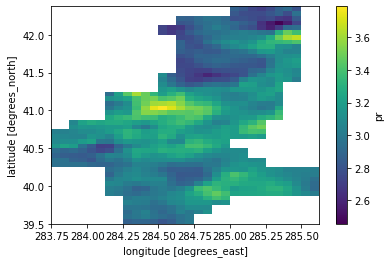

In [48]:
dp.pr.sel(projection=0).sel(time=slice('1980-01-01','1981-12-31')).mean('time').plot();

In [63]:
# Create some blank arrays to fill with each index for each projection. Write these out at the end of the loop
Rx1d = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='RX1D')
Rx5d = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='RX5D')
PTOT = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='PRCPTOT')
sdii = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='SDII')
r10 = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='R10mm')
r20 = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='R20mm')
CWD = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='CWD')
CDD = xr.DataArray(None, coords=dict(proj=proj, year=years, lat = lat, lon = lon), dims=dims, attrs=attribs, name='CDD')

for r in range(2):
    print(proj[r])
    
    ds = dp.sel(projection=r)
    ####
#    dfp = ds.sel(time=slice('2040-01-01', '2069-12-31')) # To match water availability calcs from CESM2
        
    #### Calculate indices
    Rx1d[r,:,:,:] = yearly_rx1day(ds, varname='pr')
    print('rx1d')
    Rx5d[r,:,:,:] = yearly_rx5day(ds, varname = 'pr')
    print('rx5d')
    PTOT[r,:,:,:] = xr.DataArray(indices.prcptot(ds, period='1Y', varname='pr').groupby('time.year').mean(), name='PRCPTOT') # annual total
    print('ptot')
    sdii[r,:,:,:] = xr.DataArray(indices.sdii(ds, period='1Y', varname='pr').groupby('time.year').mean(), name='SDII')
    print('sdii')

    ## Fixed threshold count of days
    r10[r,:,:,:] = xr.DataArray(indices.annual_r10mm(ds, varname='pr'), name='R10mm')
    print('r10')
    r20[r,:,:,:] = xr.DataArray(indices.annual_r20mm(ds, varname='pr'), name='R20mm')
    print('r20')

    ## Spells
    CWD[r,:,:,:] = xr.DataArray(indices.cwd(ds, period='1Y', varname='pr').groupby('time.year').mean(), name='CWD')
    print('cwd')
    CDD[r,:,:,:] = xr.DataArray(indices.cdd(ds, period='1Y', varname='pr').groupby('time.year').mean(), name='CDD')
    print('cdd')

 #####
    rx1nm = oDir + 'LOCA_CESM1.RX1D.1981-2099.nc'
    rx5nm = oDir + 'LOCA_CESM1.RX5D.1981-2099.nc'
    ptotnm = oDir + 'LOCA_CESM1.PRCPTOT.1981-2099.nc'
    sdnm = oDir + 'LOCA_CESM1.SDII.1981-2099.nc'
    r10nm = oDir + 'LOCA_CESM1.R10mm.1981-2099.nc'
    r20nm = oDir + 'LOCA_CESM1.R20mm.1981-2099.nc'
    cddnm = oDir + 'LOCA_CESM1.CDD.1981-2099.nc'
    cwdnm = oDir + 'LOCA_CESM1.CWD.1981-2099.nc'
   
        # and write out to netcdf
    Rx1d.to_netcdf(rx1nm)
    Rx5d.to_netcdf(rx5nm)
    PTOT.to_netcdf(ptotnm)
    sdii.to_netcdf(sdnm)
    r10.to_netcdf(r10nm)
    r20.to_netcdf(r20nm)
    CWD.to_netcdf(cwdnm)
    CDD.to_netcdf(cddnm)



0
rx1d
rx5d
ptot
sdii
r10
r20
cwd
cdd
1
rx1d
rx5d
ptot
sdii
r10
r20
cwd
cdd


/glade/u/home/maritye/.local/lib/python3.7/site-packages/xarray/core/nanops.py:133: RuntimeWarning: invalid value encountered in true_divide
  data = data / (valid_count - ddof)


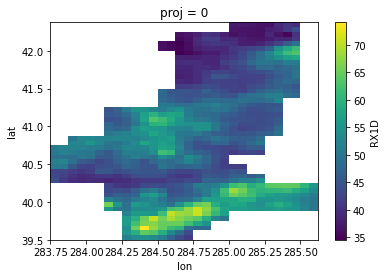

In [64]:
Rx1d.sel(proj=0).sel(year=slice('1981-01-01','2010-12-31')).mean('year').plot();

In [96]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil


/glade/u/home/maritye/.local/lib/python3.7/site-packages/xarray/core/nanops.py:133: RuntimeWarning: invalid value encountered in true_divide
  data = data / (valid_count - ddof)
/glade/u/home/maritye/.local/lib/python3.7/site-packages/xarray/core/nanops.py:133: RuntimeWarning: invalid value encountered in true_divide
  data = data / (valid_count - ddof)
/glade/u/home/maritye/.local/lib/python3.7/site-packages/xarray/core/nanops.py:133: RuntimeWarning: invalid value encountered in true_divide
  data = data / (valid_count - ddof)


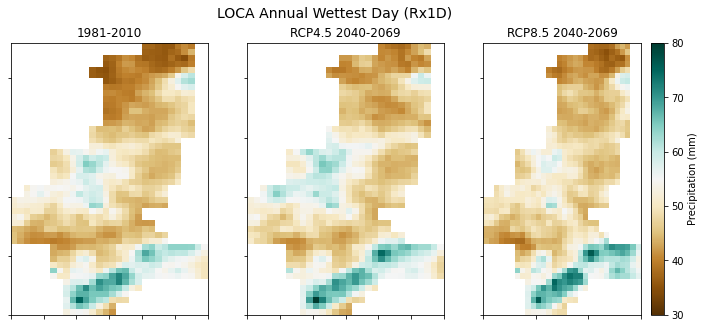

In [139]:
vmin = 30; vmax = 80

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,5))

# -----------
cmap =  plt.cm.BrBG
##
rx1cur = Rx1d.sel(year=slice('1981-01-01','2010-12-31')).mean('year').mean('proj')
rx1r45= Rx1d.sel(proj=0).sel(year=slice('2040-01-01','2069-12-31')).mean('year')
rx1r85 = Rx1d.sel(proj=1).sel(year=slice('2040-01-01','2069-12-31')).mean('year')

ax1.pcolormesh(rx1cur, vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('1981-2010')
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax2.pcolormesh(rx1r45, vmin=vmin, vmax=vmax, cmap=cmap, )
ax2.set_title('RCP4.5 2040-2069')
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
f3=ax3.pcolormesh(rx1r85, vmin=vmin, vmax=vmax, cmap=cmap,)
ax3.set_title('RCP8.5 2040-2069')
ax3.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
fig.suptitle("LOCA Annual Wettest Day (Rx1D)", fontsize=14)
fig.colorbar(f3, ax=ax3, label = 'Precipitation (mm)')

plt.show()

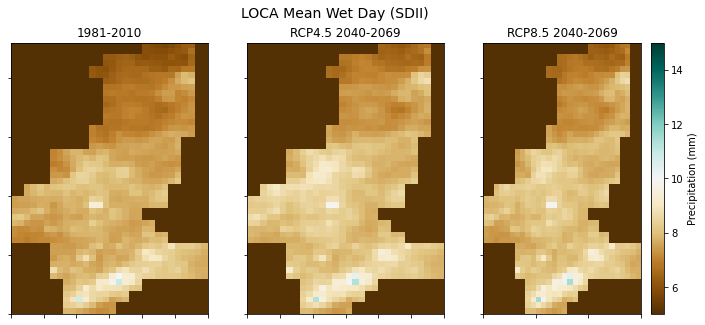

In [145]:
vmin = 5; vmax = 15

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,5))

# -----------
cmap =  plt.cm.BrBG
##
SDIIcur = sdii.sel(year=slice('1981-01-01','2010-12-31')).mean('year').mean('proj')
SDIIr45= sdii.sel(proj=0).sel(year=slice('2040-01-01','2069-12-31')).mean('year')
SDIIr85 = sdii.sel(proj=1).sel(year=slice('2040-01-01','2069-12-31')).mean('year')

ax1.pcolormesh(SDIIcur, vmin=vmin, vmax=vmax, cmap=cmap)
ax1.set_title('1981-2010')
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax2.pcolormesh(SDIIr45, vmin=vmin, vmax=vmax, cmap=cmap, )
ax2.set_title('RCP4.5 2040-2069')
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
f3=ax3.pcolormesh(SDIIr85, vmin=vmin, vmax=vmax, cmap=cmap,)
ax3.set_title('RCP8.5 2040-2069')
ax3.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
fig.suptitle("LOCA Mean Wet Day (SDII)", fontsize=14)
fig.colorbar(f3, ax=ax3, label = 'Precipitation (mm)')

plt.show()

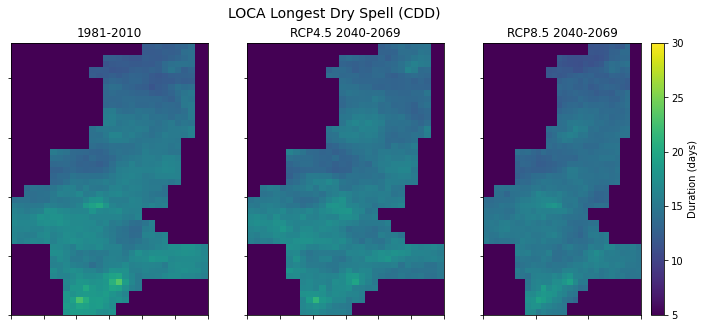

In [150]:
vmin = 5; vmax = 30

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,5))

# -----------
cmap =  plt.cm.BrBG_r
##
cddcur = CDD.sel(year=slice('1981-01-01','2010-12-31')).mean('year').mean('proj')
cddr45= CDD.sel(proj=0).sel(year=slice('2040-01-01','2069-12-31')).mean('year')
cddr85 = CDD.sel(proj=1).sel(year=slice('2040-01-01','2069-12-31')).mean('year')

ax1.pcolormesh(cddcur, vmin=vmin, vmax=vmax)
ax1.set_title('1981-2010')
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax2.pcolormesh(cddr45, vmin=vmin, vmax=vmax )
ax2.set_title('RCP4.5 2040-2069')
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
f3=ax3.pcolormesh(cddr85, vmin=vmin, vmax=vmax)
ax3.set_title('RCP8.5 2040-2069')
ax3.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
fig.suptitle("LOCA Longest Dry Spell (CDD)", fontsize=14)
fig.colorbar(f3, ax=ax3, label = 'Duration (days)')

plt.show()

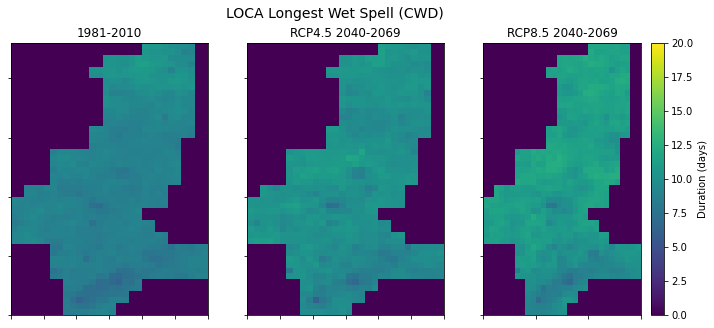

In [153]:
vmin = 0; vmax = 20

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,5))

# -----------
cmap =  plt.cm.BrBG_r
##
cwdcur = CWD.sel(year=slice('1981-01-01','2010-12-31')).mean('year').mean('proj')
cwdr45= CWD.sel(proj=0).sel(year=slice('2040-01-01','2069-12-31')).mean('year')
cwdr85 = CWD.sel(proj=1).sel(year=slice('2040-01-01','2069-12-31')).mean('year')

ax1.pcolormesh(cwdcur, vmin=vmin, vmax=vmax)
ax1.set_title('1981-2010')
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax2.pcolormesh(cwdr45, vmin=vmin, vmax=vmax )
ax2.set_title('RCP4.5 2040-2069')
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
f3=ax3.pcolormesh(cwdr85, vmin=vmin, vmax=vmax)
ax3.set_title('RCP8.5 2040-2069')
ax3.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
fig.suptitle("LOCA Longest Wet Spell (CWD)", fontsize=14)
fig.colorbar(f3, ax=ax3, label = 'Duration (days)')

plt.show()

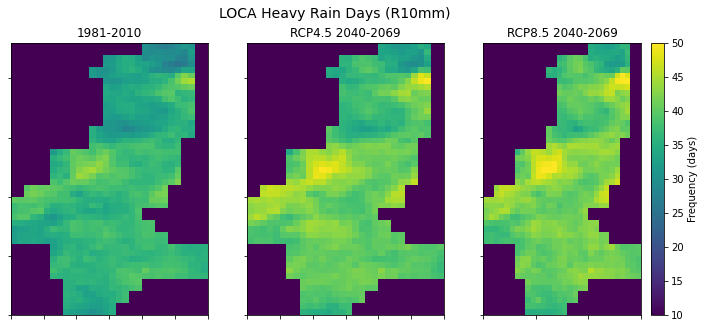

In [156]:
vmin = 10; vmax = 50

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,5))

# -----------
cmap =  plt.cm.BrBG_r
##
r10cur = r10.sel(year=slice('1981-01-01','2010-12-31')).mean('year').mean('proj')
r10r45= r10.sel(proj=0).sel(year=slice('2040-01-01','2069-12-31')).mean('year')
r10r85 = r10.sel(proj=1).sel(year=slice('2040-01-01','2069-12-31')).mean('year')

ax1.pcolormesh(r10cur, vmin=vmin, vmax=vmax)
ax1.set_title('1981-2010')
ax1.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
ax2.pcolormesh(r10r45, vmin=vmin, vmax=vmax )
ax2.set_title('RCP4.5 2040-2069')
ax2.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
f3=ax3.pcolormesh(r10r85, vmin=vmin, vmax=vmax)
ax3.set_title('RCP8.5 2040-2069')
ax3.tick_params(labelbottom=False, labeltop=False, labelleft=False, labelright=False)
fig.suptitle("LOCA Heavy Rain Days (R10mm)", fontsize=14)
fig.colorbar(f3, ax=ax3, label = 'Frequency (days)')

plt.show()